In [1]:
# Use the old version of transformers to avoid a bug.
!pip install transformers==4.35.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [2]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/MyDrive/where_contains_swda_folder")
!unzip swda.zip

Mounted at /content/drive
Archive:  swda.zip
replace swda/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an essential step in the development of dialog systems. DA tagging is a problem that is usually solved using supervised machine learning techniques, which all require a large amount of manually labeled data. For DA tagging, a variety of methods have been investigated. In this lab, we'll look at two different DA classification models. The Switchboard Dialog Act Corpus is being used for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file.

In [3]:
import pandas as pd
import glob

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm


### Bug: Reading a large number of files multiple times will cause Google Drive to crash. The temporary solution is to change to a new location, re-upload and decompress the data.

In [4]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [6]:
reduced_df = result[['act_tag','text']]


Reduce the number of tags to 43 by combining them and converting them to generic tags.

In [7]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else:
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

<ipython-input-8-3a505b615f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))


This dataset contains 43 tags. Yes-No-Question ('qy'), Statement-non-opinion ('sd'), and Statement-opinion ('sv') are some of the tags. Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags.


You can check the frequency of tags.

To get unique tags:

In [9]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [10]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [11]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [12]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [13]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [14]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


The dataset is divided into two sections: test and training.

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding),shuffle=False, stratify=None)


Pad each utterance to make them all the same length.




In [16]:
MAX_LENGTH = 128
BATCH_SZIE = 4096

In [17]:
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [18]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


In [19]:
train_input[11050]


array([  29,  236,    6,    9,   10,   52,   22,  804,  679, 7015,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [20]:
sentence_embeddings[11050]

[29, 236, 6, 9, 10, 52, 22, 804, 679, 7015]

# Model 1 -

This first model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

The model architecture is as follows: Embedding Layer (to generate word
embeddings). Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.


In [21]:
VOCAB_SIZE = len(wordvectors)+1 # 43,731
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags)

In [22]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding

#Building the network
# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=128))
# Bidirectional 1
model.add(Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True)))
# Bidirectional 2
model.add(Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=False)))

# Dense layer
model.add(Dense(HIDDEN_SIZE))
# Activation
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          4373200   
                                                                 
 bidirectional (Bidirection  (None, 128, 86)           49536     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 86)                44720     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 43)                3741      
                                                                 
 activation (Activation)     (None, 43)                0         
                                                                 
Total params: 4471197 (17.06 MB)
Trainable params: 44711

In [23]:
# Train the model - use validation

model.fit(train_input, train_labels, batch_size=128, epochs=5, validation_data=(val_input, val_labels))

Epoch 1/5
1094/1094 [==============================] - 939s 850ms/step - loss: 1.4197 - accuracy: 0.5981 - val_loss: 1.1020 - val_accuracy: 0.6595
Epoch 2/5
1094/1094 [==============================] - 913s 835ms/step - loss: 1.0228 - accuracy: 0.7006 - val_loss: 0.9470 - val_accuracy: 0.7181
Epoch 3/5
1094/1094 [==============================] - 899s 822ms/step - loss: 0.8726 - accuracy: 0.7417 - val_loss: 0.9083 - val_accuracy: 0.7163
Epoch 4/5
1094/1094 [==============================] - 917s 838ms/step - loss: 0.7783 - accuracy: 0.7660 - val_loss: 0.9104 - val_accuracy: 0.7187
Epoch 5/5
1094/1094 [==============================] - 910s 832ms/step - loss: 0.7095 - accuracy: 0.7843 - val_loss: 0.9290 - val_accuracy: 0.7154


In [24]:
score = model.evaluate(test_sentences_X, y_test, batch_size=BATCH_SZIE)

14/14 [==============================] - 74s 5s/step - loss: 1.0179 - accuracy: 0.6981


In [25]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 69.80966925621033


## Evaluation




You should look at the accuracy of some minority classes in addition to overall
accuracy. Signal-non-understanding ('br') is a good indicator of "other-repair," or situations in which the other conversational participant tries to correct the speaker's mistake. In dialogue summarization, the term "summarize/reformulate" ('bf') has been used. Report on the system's accuracy in predicting these classes, as well as any common errors you notice.

## Minority Classes

In [26]:
# Generate predictions for the test data
predictions = model.predict(test_sentences_X)


1747/1747 [==============================] - 125s 70ms/step


In [27]:
# Build the confusion matrix off these predictions
from sklearn.metrics import confusion_matrix

num_classes = predictions.shape[1]
predicted_format = np.argmax(predictions, axis=1)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)
# predicted_format = np.eye(num_cy_test = np.argmax(y_test, axis=1)lasses)[predicted_classes]

cm = confusion_matrix(predicted_format, y_test)

print('predicted_format',predicted_format)
# print('y_test',y_test.shape)



predicted_format [22 28 28 ... 22  1 28]


In [28]:

unique_tags_list=list(unique_tags)
br_index = unique_tags_list.index('br')
bf_index = unique_tags_list.index('bf')

print('br_index',br_index)
print('bf_index',bf_index)
print(cm[0])

# Calculate and print accuracies
tp_br = cm[br_index, br_index]
total_predictions_br = sum(cm[br_index, :])
accuracy_br = tp_br / total_predictions_br if total_predictions_br > 0 else 0

tp_bf = cm[bf_index, bf_index]
total_predictions_bf = sum(cm[bf_index, :])
accuracy_bf = tp_bf / total_predictions_bf if total_predictions_bf > 0 else 0

print(f"Accuracy for 'br': {accuracy_br*100:.2f}%")
print(f"Accuracy for 'bf': {accuracy_bf*100:.2f}%")

br_index 15
bf_index 13
[92 14 11  2  0  0  4  0  0  0  1  0  1  0  0  0 59  0  0 15 93  0  6  2
  1  1  0  0  2  0  0  0  1  0  0  0  0  0 84  0  0  1  6]
Accuracy for 'br': 39.66%
Accuracy for 'bf': 2.33%


## Minority Classes



Minority classes are frequently misidentified as majority classes, owing to the fact that majority classes have significantly more data and thus can be trained on. With 33 percent and 17 percent, respectively, the classes "sd" (40) and "b" (10) are the most common here.




## Minority Class showcase
The frequencies of the data are plotted in the graph below. This illustrates how some classes are common, while the majority of classes are rare.

Only 0.13 percent of the data belongs to the "br" class, while 0.42 percent belongs to the "bf" class.

In [29]:
# Print the frequency of the "br" and "bf" classes
value_counts = reduced_df["act_tag"].value_counts()
bf_frequency = value_counts["bf"]/sum(value_counts)
print("bf frequency: " + str(bf_frequency*100) + "%")

br_frequency = value_counts["br"]/sum(value_counts)
print("br frequency: " + str(br_frequency*100) + "%")

bf frequency: 0.42977379855638936%
br frequency: 0.13371734211067682%


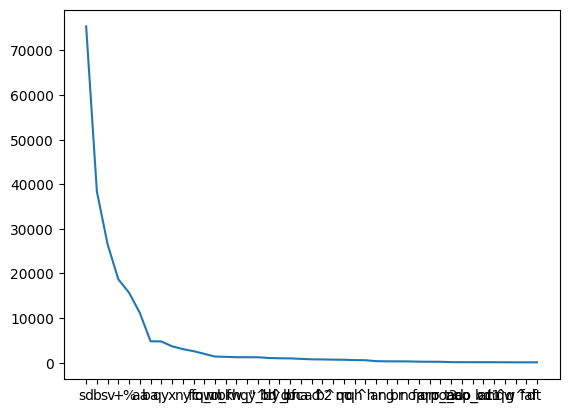

In [30]:
# Plot the frequencies of the classes

plt.plot(value_counts)

# Model 2 - Balanced Network


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training.

In [31]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [32]:
# Re-built the model for the balanced training
model_balanced = Sequential()

# Embedding layer
model_balanced.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=128))
# Bidirectional 1
model_balanced.add(Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=True)))
# Bidirectional 2
model_balanced.add(Bidirectional(LSTM(units=HIDDEN_SIZE, return_sequences=False)))

# Dense layer
model_balanced.add(Dense(HIDDEN_SIZE))
# Activation
model_balanced.add(Activation('softmax'))


model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          4373200   
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 86)           49536     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 86)                44720     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 43)                3741      
                                                                 
 activation_1 (Activation)   (None, 43)                0         
                                                                 
Total params: 4471197 (17.06 MB)
Trainable params: 447

In [33]:
# Train the balanced network - Seems to take long time to achieve good accuracy?
model_balanced.fit(x=train_input,
          y=train_labels,
          batch_size=128,
          epochs=5,
          validation_data=(val_input, val_labels),
          class_weight=d_class_weights)

Epoch 1/5
1094/1094 [==============================] - 867s 784ms/step - loss: 3.0128 - accuracy: 0.3038 - val_loss: 2.3395 - val_accuracy: 0.4073
Epoch 2/5
1094/1094 [==============================] - 885s 809ms/step - loss: 2.1969 - accuracy: 0.3954 - val_loss: 2.0942 - val_accuracy: 0.3917
Epoch 3/5
1094/1094 [==============================] - 902s 825ms/step - loss: 1.7881 - accuracy: 0.4255 - val_loss: 1.8941 - val_accuracy: 0.4455
Epoch 4/5
1094/1094 [==============================] - 882s 806ms/step - loss: 1.4857 - accuracy: 0.4607 - val_loss: 1.9738 - val_accuracy: 0.4377
Epoch 5/5
1094/1094 [==============================] - 886s 810ms/step - loss: 1.2828 - accuracy: 0.4875 - val_loss: 1.7918 - val_accuracy: 0.4765


## Test the model

In [36]:
# Overall Accuracy
from tensorflow.keras.utils import to_categorical

y_test_encoded = to_categorical(y_test, num_classes=43)
score = model_balanced.evaluate(test_sentences_X, y_test_encoded, batch_size=BATCH_SZIE)


14/14 [==============================] - 85s 6s/step - loss: 1.8428 - accuracy: 0.4605


In [37]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 46.05380892753601


In [38]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=BATCH_SZIE)

14/14 [==============================] - 78s 5s/step


## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [37]:
# Build the confusion matrix off these predictions
predicted_format = np.argmax(label_pred, axis=1)
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

cm_balanced = confusion_matrix(predicted_format, y_test)

# Calculate Accuracies for "br" and "bf"
br_index = unique_tags_list.index('br')
bf_index = unique_tags_list.index('bf')

# Calculate and print accuracies
tp_br = cm_balanced[br_index, br_index]
total_predictions_br = sum(cm_balanced[br_index, :])
accuracy_br = tp_br / total_predictions_br if total_predictions_br > 0 else 0

tp_bf = cm_balanced[bf_index, bf_index]
total_predictions_bf = sum(cm_balanced[bf_index, :])
accuracy_bf = tp_bf / total_predictions_bf if total_predictions_bf > 0 else 0

print(f"Accuracy for 'br': {accuracy_br*100:.2f}%")
print(f"Accuracy for 'bf': {accuracy_bf*100:.2f}%")

Accuracy for 'br': 17.02%
Accuracy for 'bf': 1.66%






### Explanation



### Other ways to handle imbalanced classes


- The model can be turned into multiple single-class classifiers, giving a confidence score for each of the classes. Instead of just taking the highest confidence class, the model can run the individual classifiers in ascending order of frequency of the classes in the training corpus.  The first classifier to classify the data point over a certain confidence threshold determines the class given to the example. This gives chance for the minority class classifiers to classify before the frequent classes arrive with their more confident predicitions.

- Transfer Learning could also be implemented, to initialise weights on a larger dataset, where these minority classes may be prevelant. This would allow fine-tuning with the small data for this particular application.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of
previous DA tags, plus the utterance representation.

# Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current utterance.

To make it easier to train, we combined all of the utterances into one long sequence rather than breaking them up into individual dialogues.

Notes: please reduce the BATCH_SIZE and the input size of data to run the following code.


## Define the model

This model has an architecture of:

- BERT Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output


## BERT Word Embedding

### Please refer back to Lab3 for more information.

In [38]:
from transformers import DistilBertTokenizer, RobertaTokenizer
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick a pre-trained model

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=MAX_LENGTH, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=MAX_LENGTH, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')

    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Preprocess the dataset to make it be proper input of BERT

In [39]:
# Preprocess the dataset to make it be proper input of BERT
x_sen_int, x_sen_masks, _ = tokenize(sentences, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Split dataset into Train and Test set

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np
# split datasets
X_train, X_test, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    x_sen_int, x_sen_masks, np.array(tags_encoding),shuffle=False, stratify=None
)

In [41]:
# Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

# train_input_sen = X_train[:140000]
# train_input_mask = X_train_mask[:140000]
# train_input = [train_input_sen, train_input_mask]

# val_input_sen = X_train[140000:]
# val_input_mask = X_train_mask[140000:]
# val_input = [val_input_sen, val_input_mask]

# train_labels = y_train[:140000]
# val_labels = y_train[140000:]

train_input_sen = X_train[:140000]
train_input_mask = X_train_mask[:140000]
train_input = [train_input_sen[:1000], train_input_mask[:1000]]

val_input_sen = X_train[140000:]
val_input_mask = X_train_mask[140000:]
val_input = [val_input_sen[:1000], val_input_mask[:1000]]

train_labels = y_train[:140000]
val_labels = y_train[140000:]

In [42]:
print(X_train[0])
print(X_train_mask[0])
print(y_train[0])

[ 101  100  100 1013  102    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[False False False False False False False False False False False False
 False False Fa

### Get BERT Layer

In [43]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## CNN


This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [44]:
import tensorflow as tf

from keras.models import Model,Sequential
from keras.layers import LSTM
from keras import Input
from keras.layers import Dense, Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, TimeDistributed
from keras.optimizers import Adam
from keras.layers import Reshape, Conv2D, BatchNormalization,MaxPool2D,Concatenate, Flatten


filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors)+1 # 43,731
MAX_LENGTH = 128
EMBED_SIZE = 768 # fixed
HIDDEN_SIZE = len(unique_tags)

In [45]:
# BERT Embedding Layer
input_ids_in =Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
input_masks_in =Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_masks')
bert_embeddings = get_BERT_layer()
embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [46]:
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedded_sent)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

In [47]:
# concatenate tensors
concatenated = Concatenate(axis=-1)([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flatten = TimeDistributed(Flatten())(concatenated)
# dense layer (dense_1)
dense_1 = Dense(EMBED_SIZE, activation='relu')(flatten)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)
dense_1.shape

TensorShape([None, 1, 768])

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.
    

In [48]:
# BLSTM model

# Bidirectional 1
BiLSTM = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True))(dropout_1)
# Bidirectional 2
BiLSTM = Bidirectional(LSTM(units=EMBED_SIZE))(BiLSTM)

# Dense layer (dense_2)
dense_2 = Dense(EMBED_SIZE, activation='relu')(BiLSTM)

flatten_2 = Flatten()(dense_2)

# dropout_2
dropout_2 = Dropout(drop)(dense_2)

Concatenate 2 last layers and create the output layer
network

In [49]:
# concatenate 2 final layers
concatenated_layer = Concatenate(axis=1)([flatten_2, dropout_2])

# output
output = Dense(len(unique_tags), activation='softmax')(concatenated_layer)

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.
layer

In [53]:
# Train the model - using validation
model2 = Model(inputs=[input_ids_in, input_masks_in], outputs=output)
model2.summary()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(x=train_input, y=train_labels[:1000], epochs=1, batch_size=32,
           validation_data=(val_input, val_labels[:1000]), verbose=1)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 input_masks (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 128, 768)   0          'input_masks[0][0]']         
                             , hidden_states=None, atte                                           
                             ntions=None)                                                   

In [51]:
score = model2.evaluate([X_test, X_test_mask], y_test, batch_size=32)

1747/1747 [==============================] - 11803s 7s/step - loss: 2.4727 - accuracy: 0.3261


In [52]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 32.60885179042816
